## Importando as bibliotecas

In [2]:
#Importação dos pacotes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler
import seaborn as sns
import itertools  #loops e interações
import statsmodels.api as sm  #modelo estatístico
from datetime import datetime
from statsmodels.graphics.tsaplots import month_plot, quarter_plot  #tsa - time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose 
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf  #calcular função de autocorrelação 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf #gerar gráfico da função de autocorrelação e autocorr. parcial
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff  #diff - diferenciação da série
from statsmodels.tsa.arima.model import ARIMA #Incluido por mim para tentar solucuonar o erro na célula 46
#from statsmodels.tsa.arima_model import ARIMA  #calculo do modelo ARIMA
#from statsmodels.tsa.arima_model import ARMA  #calculo do modelo ARMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.stattools import jarque_bera
import scipy.stats as sct
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error  #métrica erro médio absoluto
from sklearn.metrics import mean_squared_error  #métrica erro médio quadrático
from pmdarima import auto_arima  #autoarima para fazer a busca automática dos parâmetros do modelo
from pmdarima.arima import ADFTest  #test Dick Fuller para avaliar a estacionariedade da série
from statsmodels.tsa.statespace.sarimax import SARIMAX #cáculo de modelo sazonal e com variáveis exógenas
from xgboost import XGBRegressor
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

### Importando a base de Acessos e colocando o campo 'Data' como o index

In [3]:
df = pd.read_csv('Acessos_Banda_Larga_Fixa_Total_2020_2022.csv',index_col='Data',parse_dates=True)
df.index.freq = 'MS'
df.head(5)

,Acessos
Data,
2020-01-01,32937919
2020-02-01,33175908
2020-03-01,33216768
2020-04-01,33582173
2020-05-01,33901720


In [4]:
df.shape

(31, 1)

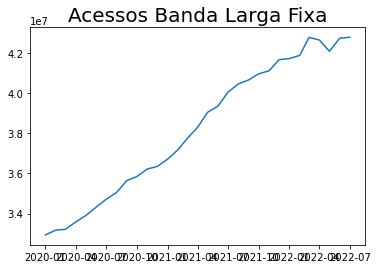

In [7]:
#Visualização dos dados
plt.title('Acessos Banda Larga Fixa', size=20)
plt.plot(df);

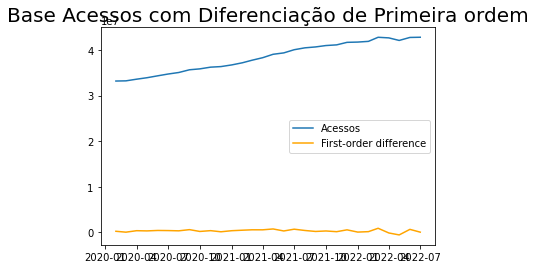

In [8]:
# Comportamento da diferenciação da série
# diff() calculates the difference of a DataFrame element compared with another element
# in the DataFrame (default is element in the previous row).

df['Acessos_Diff'] = df['Acessos'].diff(periods=1)
df = df.dropna()

# Plot
plt.title('Base Acessos com Diferenciação de Primeira ordem', size=20)
plt.plot(df['Acessos'], label='Acessos')
plt.plot(df['Acessos_Diff'], label='First-order difference', color='orange')
plt.legend();

In [9]:
#Teste de estacionariedade série original
# p valor = 0.99 --> indica que a série é não estacionária
adfuller(df["Acessos"])

(-2.337093679828698,
 0.16028338187266755,
 8,
 21,
 {'1%': -3.7883858816542486,
  '5%': -3.013097747543462,
  '10%': -2.6463967573696143},
 566.2215573331595)

In [10]:
#Teste de estacionariedade série diferenciada
adfuller(df["Acessos_Diff"])

(-1.3975934324191437,
 0.5834293119082741,
 2,
 27,
 {'1%': -3.6996079738860943,
  '5%': -2.9764303469999494,
  '10%': -2.627601001371742},
 567.5028486598288)

In [11]:
#Cálculo da autocorrelação
acf_values = acf(df['Acessos_Diff'])
np.round(acf_values,2)

array([ 1.  , -0.09, -0.08,  0.33, -0.09, -0.05,  0.  , -0.02,  0.15,
       -0.14,  0.02,  0.02, -0.26, -0.02, -0.21])

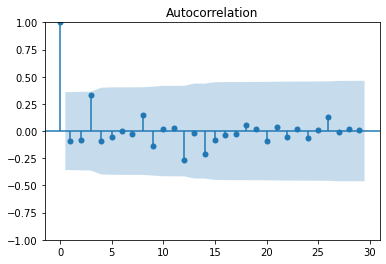

In [12]:
#Gráfico da autocorrelação
plot_acf(df['Acessos_Diff'], lags=29);

In [13]:
#Cálculo da autocorrelação parcial
pacf_values = pacf(df['Acessos_Diff'])
np.round(pacf_values,2)

array([ 1.  , -0.1 , -0.09,  0.35, -0.05, -0.03, -0.16,  0.01,  0.26,
       -0.16,  0.03, -0.2 , -0.36, -0.13, -0.64])

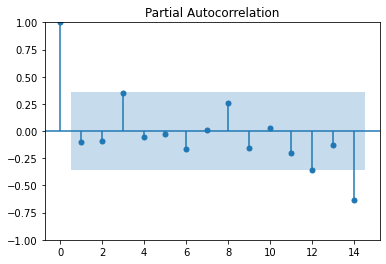

In [14]:
#Gráfico da autocorrelação parcial
plot_pacf(df['Acessos_Diff'], lags=14);

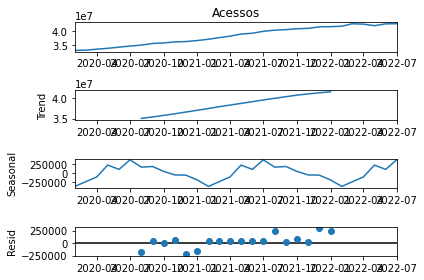

In [15]:
#Decomposição sazonal para ver os componentes
result = seasonal_decompose(df['Acessos'], 
                            model ='additive')
result.plot();

In [16]:
#Ajustar auto arima para a base
stepwise_fit = auto_arima(df['Acessos'], start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=543.374, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=781.051, Time=0.23 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=543.821, Time=0.18 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=608.647, Time=0.02 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=543.430, Time=0.12 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=542.710, Time=0.05 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=539.458, Time=0.21 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=541.141, Time=0.66 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=541.140, Time=0.95 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=539.340, Time=0.31 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=540.102, Time=0.19 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=545.074, Time=0.51 sec
 ARIMA(0,0,0)(0,1,2)[12]             : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:                             y   No. Observations:                   30
Model:             SARIMAX(0, 1, [1, 2], 12)   Log Likelihood                -265.967
Date:                       Wed, 28 Sep 2022   AIC                            537.934
Time:                               11:00:20   BIC                            540.605
Sample:                           02-01-2020   HQIC                           538.303
                                - 07-01-2022                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.1310      0.014      9.298      0.000       0.103       0.159
ma.S.L24       0.1176      0.008     15.435      0.000       0.103       0.133
sigma2      5.439e+11        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   3.57   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.06   Prob(JB):                         1.00
Heteroskedasticity (H):               6.73   Skew:                            -0.01
Prob(H) (two-sided):                  0.04   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.18e+44. Standard errors may be unstable.
"""

In [17]:
#Tamanho da Base
df.shape

(30, 2)

In [18]:
#Separa a base em treino e teste
train = df.iloc[:len(df)-6]
test = df.iloc[len(df)-6:] # Deixa 6 meses para teste

In [19]:
#Ajusta um modelo SARIMAX(0, 0, 0)x(0, 1, 2, 12) na base de treinamento
model = SARIMAX(train['Acessos'], 
                order = (0, 0, 0), 
                seasonal_order =(0, 1, 2, 12))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:                       Acessos   No. Observations:                   24
Model:             SARIMAX(0, 1, [1, 2], 12)   Log Likelihood                -168.913
Date:                       Wed, 28 Sep 2022   AIC                            343.825
Time:                               11:00:59   BIC                            345.280
Sample:                           02-01-2020   HQIC                           343.287
                                - 01-01-2022                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.1491      0.936      0.159      0.873      -1.686       1.984
ma.S.L24      -0.0254      5.574     -0.005      0.996     -10.951      10.900
sigma2      1.218e+11   4.78e-10   2.55e+20      0.000    1.22e+11    1.22e+11
===================================================================================
Ljung-Box (L1) (Q):                   1.14   Jarque-Bera (JB):                 0.69
Prob(Q):                              0.28   Prob(JB):                         0.71
Heteroskedasticity (H):               0.20   Skew:                            -0.59
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.36e+37. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='Data'>

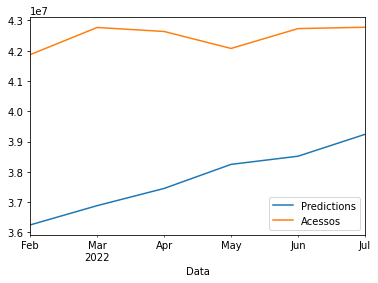

In [20]:
#Predição do modelo ARIMA na base de teste
start = len(train)
end = len(train) + len(test) - 1
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
predictions.plot(legend = True)
test['Acessos'].plot(legend = True)

In [21]:
#Cálculo da acurácia das previsões (raiz do erro medio quadratico)
rmse(test["Acessos"], predictions)

4797169.732424109

In [22]:
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error

In [23]:
print((metrics.mean_absolute_percentage_error(test["Acessos"], predictions)*100).round(2))

11.1


#### Escolha automática de parâmetros por meio do auto.arima

In [25]:
# Importando a base de Acessos e colocando o campo 'Data' como o index
df = pd.read_csv('Acessos_Banda_Larga_Fixa_Total_2020_2022.csv',index_col='Data',parse_dates=True)
df.index.freq = 'MS'
df.head(5)

,Acessos
Data,
2020-01-01,32937919
2020-02-01,33175908
2020-03-01,33216768
2020-04-01,33582173
2020-05-01,33901720


<AxesSubplot:xlabel='Data'>

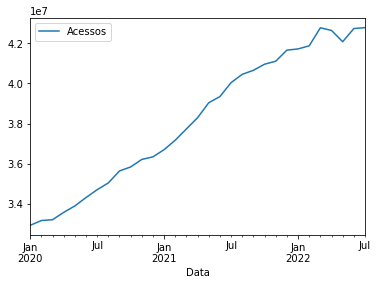

In [26]:
#Visualizando os dados
df.plot()

In [27]:
#Teste de estacionariedade da série
adfuller(df)

(-2.3879512527173707,
 0.145165995896134,
 8,
 22,
 {'1%': -3.769732625845229,
  '5%': -3.005425537190083,
  '10%': -2.6425009917355373},
 592.9890802749567)

In [28]:
df.shape

(31, 1)

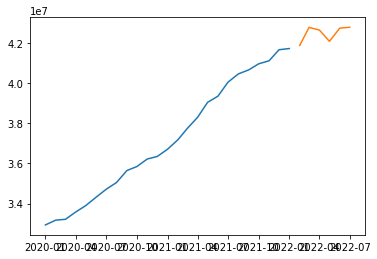

In [30]:
#Separação da base em treino e teste

train = df.iloc[:len(df)-6]
test = df.iloc[len(df)-6:] # Deixa 6 meses para teste

plt.plot(train)
plt.plot(test)

In [31]:
#Especificação do modelo ARIMA
arima_model=auto_arima(train, start_p=0, d=1, start_q=0, 
                      max_p=5, max_d=5, max_q=5, start_P=0,
                      D=1, start_Q=5, max_P=5, max_D=5, max_Q=5, 
                      m=12, seasonal=True, error_action="warn",
                      trace=True, suppress_warnings=True, stepwise=True,
                      random_state=20, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,5)[12]             : AIC=349.156, Time=1.12 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=343.618, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=341.955, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=342.677, Time=0.07 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=340.872, Time=0.03 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=341.955, Time=0.06 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=343.955, Time=0.09 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=340.053, Time=0.04 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=340.315, Time=0.15 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=340.316, Time=0.17 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=342.309, Time=0.22 sec
 ARIMA(3,1,0)(0,1,0)[12]             : AIC=341.325, Time=0.12 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=339.341, Time=0.16 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=339.615, Time=0.28 sec
 ARIMA(2,1,1)(0,1,1)[12]         

In [32]:
#Resumo do modelo
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   25
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -166.503
Date:                             Wed, 28 Sep 2022   AIC                            339.006
Time:                                     11:01:47   BIC                            340.460
Sample:                                 01-01-2020   HQIC                           338.467
                                      - 01-01-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7375      0.164      4.489      0.000       0.415       1.059
ma.L1         -0.7509      0.161     -4.656      0.000      -1.067      -0.435
sigma2      5.123e+10   6.82e-13   7.51e+22      0.000    5.12e+10    5.12e+10
===================================================================================
Ljung-Box (L1) (Q):                   4.93   Jarque-Bera (JB):                 0.69
Prob(Q):                              0.03   Prob(JB):                         0.71
Heteroskedasticity (H):               2.23   Skew:                             0.02
Prob(H) (two-sided):                  0.46   Kurtosis:                         1.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.05e+39. Standard errors may be unstable.
"""

In [33]:
#Prevendo valores na base de teste
prediction=pd.DataFrame(arima_model.predict(n_periods=6), index=test.index)
prediction.columns = ['predicted_acessos']
prediction

,predicted_acessos
Data,
2022-02-01,4.220146e+07
2022-03-01,4.277264e+07
2022-04-01,4.333699e+07
2022-05-01,4.408854e+07
2022-06-01,4.439813e+07
2022-07-01,4.509605e+07


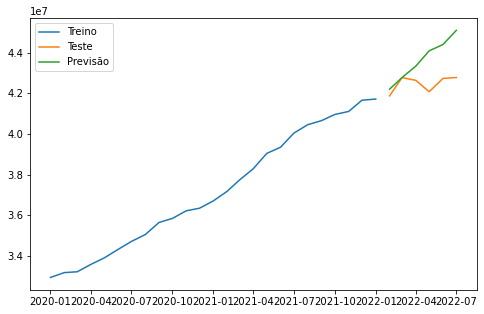

In [34]:
#Visualização das previsões
plt.figure(figsize=(8,5))
plt.plot(train, label="Treino")
plt.plot(test, label="Teste")
plt.plot(prediction, label="Previsão")
plt.legend(loc="upper left")
plt.show()

In [35]:
#Cálculo da acurácia das previsões (raiz do erro medio quadratico)
rmse(test["Acessos"], prediction["predicted_acessos"])

1460820.6855522275

In [36]:
print(rmse(test["Acessos"], prediction["predicted_acessos"]).round(2))

1460820.69


In [37]:
print((metrics.mean_absolute_percentage_error(test["Acessos"], prediction["predicted_acessos"])*100).round(2))

2.76


In [35]:
# Resultados Alcançados

# Ajuste Manual com Sarimax
# train = df.iloc[:len(df)-12]   91%
# test = df.iloc[len(df)-12:]     9%
# n_periods=12 
# acurácia = 1213500.2779354854  3% de erro

# Auto-Arima
# train = df.iloc[:len(df)-12]   91%
# test = df.iloc[len(df)-12:]     9%
# n_periods=12 
# acurácia = 2134011.8756925566  5% de erro

# Auto-Arima
# train=df[:110] 80%
# test=df[-29:]  20%
# n_periods=29 
# acurácia = 3841679.646264531  9% de erro